In [1]:
# needed so that build files can be executed in the right directory
import os
if "build" in os.getcwd():
    os.chdir('..')
if "experiments" in os.getcwd():
    os.chdir('..')    

# Tools

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import seaborn as sns
import simplejson as json
import os
from datetime import timedelta
import webbrowser
import papermill as pm
from enum import Enum
import re
import simplejson as json
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import IsolationForest
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from collections import Counter

In [3]:
# InteractiveShell.ast_node_interactivity = "all"
%env GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json
client = bigquery.Client()

env: GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json


# Configuration

In [4]:
max_number_of_clusters_kmeans = 30
min_number_of_clusters_kmeans = 2
contamination = 0.01

class OUTLIER_REMOVAL(Enum):
    NONE = 1 
    VARIANCE_THRESHOLD_WITHIN_CLUSTER = 2 
    ISOLATION_FOREST = 3 

outlier_removal = OUTLIER_REMOVAL.VARIANCE_THRESHOLD_WITHIN_CLUSTER.value

class CLUSTER_METHOD(Enum):
    KMEANS = 1 
    OPTICS = 2 

cluster_method = CLUSTER_METHOD.KMEANS.value
   
include_features = "all"    
    
reset_clustering_result = False

In [5]:
number_of_addresses = 10000

# format: yyyy-mm-dd
observation_period_start = "2019-06-01 00:00:00+00" 
observation_period_end = "2020-01-01 00:00:00+00"

class ADDRESS_SELECTION(Enum):
    RANDOM = 1 # selects random features.index, that have been active within the observation period.
    RICHEST = 2 # selects the accounts that have the most ether # not yet implemented
    HIGHEST_TURNOVER = 3 # selects the accounts that have the most ether received + sent

address_selection = ADDRESS_SELECTION.HIGHEST_TURNOVER.value

# max USD amount to spent for executing sql queries
max_bigquery_costs_usd = 2

# Delete existing tables
reset_feature_tables = False

# Create feature table in bigquery

In [6]:
# todo: eindeutige id in form von einem hash welcher auch die attribute umfasst
table_name = "features"
table_id = "{}_{}_{}_{}_{}".format(table_name, ADDRESS_SELECTION(address_selection).name, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end))

In [7]:
try:
    pm.execute_notebook(
       './features/features.ipynb',
       './build/{}.build.ipynb'.format(table_id),
       parameters = dict(number_of_addresses=number_of_addresses, observation_period_start=observation_period_start,observation_period_end=observation_period_end, address_selection=address_selection,max_bigquery_costs_usd=max_bigquery_costs_usd, reset = reset_feature_tables),
       cwd = "./features"
    )
except Exception as e:
    if "does already exist" in e.args[0]:
        print("Feature table does already exist.")
        pass
    else:
        raise

# Load feature table from bigquery

In [8]:
filename = '{}.json'.format(table_id)
data_dir = "./data"

if filename not in os.listdir("./data") or reset_feature_tables == True:
     
    print("Loading data from bigquery ...")
    
    sql = """
        SELECT *
        FROM `masterarbeit-245718.ethereum_us.{table_id_features}` 
        """.format(table_id_features = table_id)

    query_job = client.query(sql)  
    
    start = time.time();
    
    features = query_job.result().to_dataframe(); 
    features = features.set_index("address")
    
    done = time.time();
    elapsed = round(done - start);
    
    print("Time to retrieve data from BigQuery: {} Minutes.".format(round(elapsed/60)))
    
    with open('{}/{}'.format(data_dir, filename), 'w') as json_file:
        json.dump(features.to_dict(), json_file, use_decimal=True, default=str)
        
else: 
    
    print("Loading data from local cache ...")
    
    start = time.time();
    
    with open('./data/{}'.format(filename), "r") as file:  
        file_content_json = json.load(file);
        
    done = time.time();
    elapsed = round(done - start);
    
    features = pd.DataFrame(file_content_json) 
    
    print("Time to retrieve data from local cache: {} Seconds.".format(elapsed))
        
features = features.dropna()

Loading data from bigquery ...
Time to retrieve data from BigQuery: 0 Minutes.


In [9]:
m = features.memory_usage();
total_bytes = m.sum();
total_megabytes = total_bytes/10**6;
print("Size of the account feature dataset: {} Megabytes.".format(round(total_megabytes)))

Size of the account feature dataset: 2.0 Megabytes.


# Set avg_time_diff and stddev 0 values to max

In [10]:
features = features[features["avg_time_diff_sent_tx"] != 0]
features = features[features["avg_time_diff_received_tx"] != 0]
features = features[features["stddev_received_tx"] != 0]
features = features[features["stddev_sent_tx"] != 0]

print("Es wurden {} Adressen eliminiert.".format(number_of_addresses-len(features)))

Es wurden 2622 Adressen eliminiert.


# Exclude features

In [11]:
if include_features == "all":
    include_features = ['wei_received', 'wei_sent', 'balance', 'number_of_tx_received',
       'number_of_tx_sent', 'avg_time_diff_received_tx',
       'avg_time_diff_sent_tx', 'mined_blocks', 'stddev_received_tx',
       'stddev_sent_tx', 'active_months', 'usd_received', 'usd_sent',
       'avg_wei_sent', 'avg_wei_received', 'avg_usd_sent', 'avg_usd_received',
       'monthly_wei_sent', 'monthly_wei_received', 'monthly_usd_sent',
       'monthly_usd_received', 'monthly_outgoing_txns',
       'monthly_incoming_txns', 'number_of_contracts_created', 'contract_tx',
       'diff_token_used']
        
features = features[include_features]

# Standardise feature values, so that all feature values have the same mean and stddev

In [12]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
features_std = scaler.fit_transform(features);
features_std = pd.DataFrame(features_std, columns=features.columns, index=features.index);

# Plot the three principal component attribut values with outliers

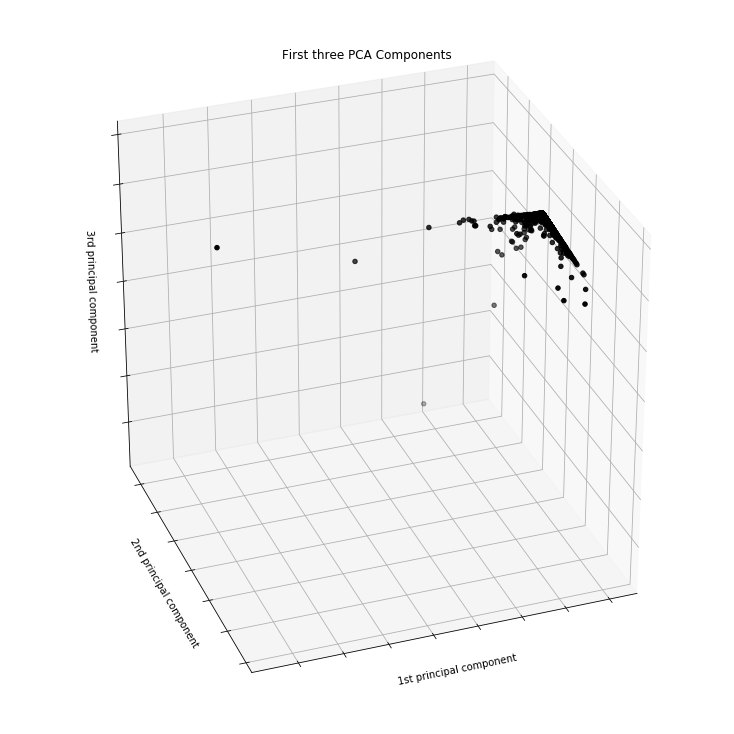

In [13]:
from mpl_toolkits.mplot3d import Axes3D;

fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

pca_tmp = PCA(n_components=3)
features_std_pca_tmp = pca_tmp.fit_transform(features_std);
features_std_pca_tmp = pd.DataFrame(features_std_pca_tmp)
features_std_pca_tmp.index = features.index 
features_std_pca_tmp.columns = ["1st eigenvector", "2st eigenvector", "3st eigenvector"] 

ax.scatter(features_std_pca_tmp["1st eigenvector"], 
           features_std_pca_tmp["2st eigenvector"],
           features_std_pca_tmp["3st eigenvector"], c="black");

ax.set_title("First three PCA Components");
ax.set_xlabel("1st principal component");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd principal component");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd principal component");
ax.w_zaxis.set_ticklabels([]);

# Use Isolationforest to identify outliers

In [14]:
clf = IsolationForest(max_samples="auto", behaviour='new', contamination=contamination)

clf.fit(features_std)
pred = clf.predict(features_std)

features_clean = features[pred == 1]
features_std_clean = features_std[pred == 1]

outliers = features[pred == -1]

print("Number of detected outliers: {}".format(outliers.shape[0]))

Number of detected outliers: 74


In [15]:
# Display outliers
outliers_tmp = outliers.copy()
outliers_tmp["turnover"] = outliers["wei_received"] + outliers["wei_sent"]
outliers_tmp = outliers_tmp.sort_values(by=["turnover"], ascending=False)
outliers_tmp.head(100)

,wei_received,wei_sent,balance,number_of_tx_received,number_of_tx_sent,avg_time_diff_received_tx,avg_time_diff_sent_tx,mined_blocks,stddev_received_tx,stddev_sent_tx,...,monthly_wei_sent,monthly_wei_received,monthly_usd_sent,monthly_usd_received,monthly_outgoing_txns,monthly_incoming_txns,number_of_contracts_created,contract_tx,diff_token_used,turnover
address,,,,,,,,,,,,,,,,,,,,,
0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,17198743185703589029081791,17117294026529545432348298,81449159174043596733493,724880,480131,2.550554e+01,3.850928e+01,0,1.534869e+02,1.145612e+02,...,2445327718075649347478328.285714286,2456963312243369861297398.714285714,5.077694e+08,5.097466e+08,6.859014e+04,103554.285714,0,317155,122,34316037212233134461430089
0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,7185636033112714484322771,6503167334760452922982501,682468698352261561340270,3853832,358400,4.797698e+00,5.158812e+01,0,1.617549e+01,9.510700e+01,...,929023904965778988997500.142857143,1026519433301816354903253,1.710350e+08,1.826999e+08,5.120000e+04,550547.428571,0,0,1,13688803367873167407305272
0x6cc5f688a315f3dc28a7781717a9a798a59fda7b,5584183598257985368124640,5867677762000000000000000,-283494163742014631875360,153607,460491,1.147539e+02,4.015135e+01,0,1.107479e+04,1.089046e+02,...,838239680285714285714285.714285714,797740514036855052589234.285714286,1.925297e+08,1.845616e+08,6.578443e+04,21943.857143,0,449764,369,11451861360257985368124640
0x5e032243d507c743b061ef021e2ec7fcc6d3ab89,4248915115389995318482829,4299720909969814553442786,-50805794579819234959957,283376,210033,6.415535e+01,7.381898e+01,0,3.715381e+03,1.939714e+02,...,614245844281402079063255.142857143,606987873627142188354689.857142857,1.347024e+08,1.347066e+08,3.000471e+04,40482.285714,0,2,1,8548636025359809871925615
0x876eabf441b2ee5b5b0554fd502a8e0600950cfa,4283216581661081039674815,4236039777146300000000000,47176804514781039674815,79018,86106,2.339709e+02,2.146998e+02,0,3.329833e+02,3.825460e+02,...,605148539592328571428571.428571429,611888083094440148524973.571428571,1.340177e+08,1.349635e+08,1.230086e+04,11288.285714,0,44230,120,8519256358807381039674815
0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,3868730536783775039068891,4250896805463919800000000,-382166268680144760931109,176112,87022,1.049869e+02,2.124618e+02,0,1.459638e+02,3.190265e+02,...,607270972209131400000000,552675790969110719866984.428571429,1.258167e+08,1.123773e+08,1.243171e+04,25158.857143,0,0,0,8119627342247694839068891
0xfa52274dd61e1643d2205169732f29114bc240b3,3868724606334355122823040,3868724606334355122823040,0,176092,176092,1.049988e+02,1.049988e+02,0,1.459817e+02,1.459817e+02,...,552674943762050731831862.857142857,552674943762050731831862.857142857,1.123772e+08,1.123772e+08,2.515600e+04,25156.000000,0,0,0,7737449212668710245646080
0x0681d8db095565fe8a346fa0277bffde9c0edbbf,3811773248376168907543830,3798894956478730000000000,12878291897438907543830,522,410957,3.539654e+04,4.499134e+01,0,3.139619e+04,1.278565e+02,...,542699279496961428571428.571428571,544539035482309843934832.857142857,1.128378e+08,1.132472e+08,5.870814e+04,74.571429,0,256583,112,7610668204854898907543830
0x564286362092d8e7936f0549571a803b203aaced,3772117193726925634204226,3763210880226730000000000,8906313500195634204226,499,416111,3.696888e+04,4.443408e+01,0,3.148146e+04,1.264220e+02,...,537601554318104285714285.714285714,538873884818132233457746.571428571,1.110708e+08,1.113345e+08,5.944443e+04,71.285714,0,261847,115,7535328073953655634204226


In [16]:
filename_outliers = "outliers_{}_{}_{}_{}_{}_{}_{}.json".format(address_selection, outlier_removal, cluster_method, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end), hash(str(include_features)))
with open('{}/{}'.format(data_dir, filename_outliers), 'w') as json_file:
    json.dump(features.to_dict(), json_file, use_decimal=True, default=str)

# Use Isolationforest to remove outliers

In [18]:
if outlier_removal == OUTLIER_REMOVAL.ISOLATION_FOREST.value:
    features = features_clean
    features_std = features_std_clean

# Dimension Reduction via Principal Component Analysis

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 90% ausreicht.

In [19]:
min_explained_variance = 0.8

In [20]:
pca = PCA().fit(features_std)
optimal_number_of_clusters = 0
for i in np.cumsum(pca.explained_variance_ratio_):
    optimal_number_of_clusters = optimal_number_of_clusters + 1
    if i > min_explained_variance:
        break;

print("Die {} ersten PCA-Komponenten erklären mehr als {}% der Varianz.".format(optimal_number_of_clusters, min_explained_variance*100))

Die 7 ersten PCA-Komponenten erklären mehr als 80.0% der Varianz.


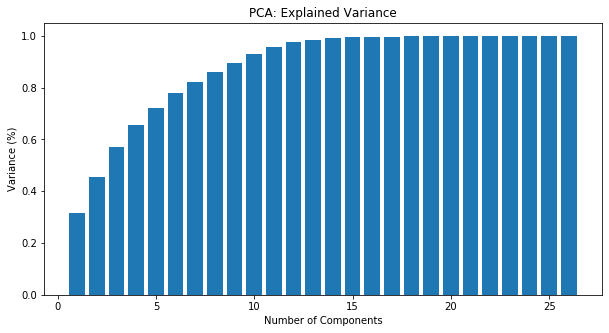

In [21]:
plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1, 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA: Explained Variance')
plt.show()

In [22]:
pca = PCA(n_components=optimal_number_of_clusters);
features_std_pca = pca.fit_transform(features_std);
features_std_pca = pd.DataFrame(features_std_pca);
features_std_pca.index = features.index
features_std_pca.head()

,0,1,2,3,4,5,6
address,,,,,,,
0x55989d7c24e0e4c5c5bb9b0bdcdbe9d6f9991f34,-0.831348,-4.404713,1.585845,-2.550502,0.238476,-0.237481,-0.260416
0xb9ca3ca6c8ca270b812da4a9aab8b935e8e6c4a7,-0.705530,-2.925644,1.021172,-1.644294,0.124817,-0.163532,-0.344544
0x936dc23be745befe40b1a72f7f244bc5627788ec,-0.605236,-1.911157,0.623427,-0.963138,0.030239,-0.102040,-0.417126
0xaf8b506eebdd567d4a982abf949a85c704117acb,-0.665303,-5.033697,1.663202,-1.910231,0.071729,-0.069710,-0.487435
0x01b54f22deff4e08365c731d923a31379aef62ff,-0.005139,-1.906712,0.212815,1.669474,-0.456933,0.444639,-0.629570


# Plot the three principal component attribut values without outliers

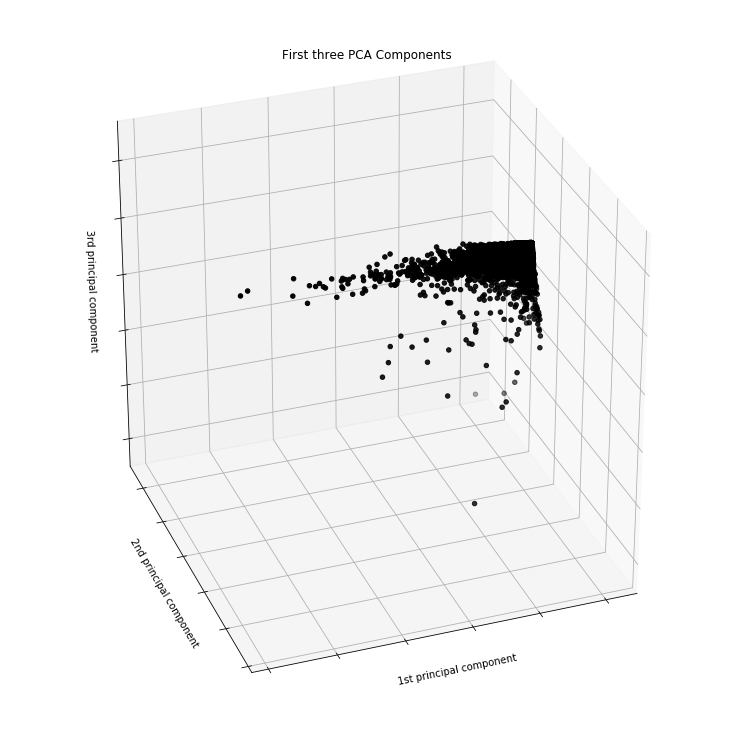

In [23]:
from mpl_toolkits.mplot3d import Axes3D;

fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

pca_tmp = PCA(n_components=3)
features_std_pca_tmp = pca_tmp.fit_transform(features_std_clean);
features_std_pca_tmp = pd.DataFrame(features_std_pca_tmp)
features_std_pca_tmp.index = features_std_clean.index 
features_std_pca_tmp.columns = ["1st eigenvector", "2st eigenvector", "3st eigenvector"] 

ax.scatter(features_std_pca_tmp["1st eigenvector"], 
           features_std_pca_tmp["2st eigenvector"],
           features_std_pca_tmp["3st eigenvector"], c="black");

ax.set_title("First three PCA Components");
ax.set_xlabel("1st principal component");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd principal component");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd principal component");
ax.w_zaxis.set_ticklabels([]);

# Caluclate number of clusters via Clinski Harabasz Score (only when using K-MEANS)

In [24]:
def estimateNumberOfClusters(features, features_std_pca, max_number_of_clusters_kmeans):
    scores = []
    numberOfCluster = []

    for i in range(2,max_number_of_clusters_kmeans,1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(features_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(features, kmeans_tmp.labels_))  
    
    result = pd.DataFrame(np.transpose(np.array([numberOfCluster, scores])).astype(int), columns=["Number of Clusters", "C.H. Score"]);
    optimal_number_of_clusters = numberOfCluster[np.argmax(scores)];
    
    return result, optimal_number_of_clusters;

In [25]:
def plotScores(scores):
    plt.figure()
    plt.bar(scores.iloc[:, 0],scores.iloc[:, 1] )
    plt.xlabel('Number of Clusters')
    plt.ylabel('C.H. Score') #for each component
    plt.title('Calinski Harabasz Score')
    plt.show()

In [26]:
if cluster_method == CLUSTER_METHOD.KMEANS.value:
    scores = []
    numberOfCluster = []
    
    # 3 clusters are not considered to be valid
    for i in range(min_number_of_clusters_kmeans, max_number_of_clusters_kmeans, 1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(features_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(features, kmeans_tmp.labels_))  
    
    results = pd.DataFrame(zip(numberOfCluster, scores), columns=["number_of_clusters", "calinski_score"])
    optimal_number_of_clusters = results.loc[results["calinski_score"].idxmax()].astype(int)["number_of_clusters"]

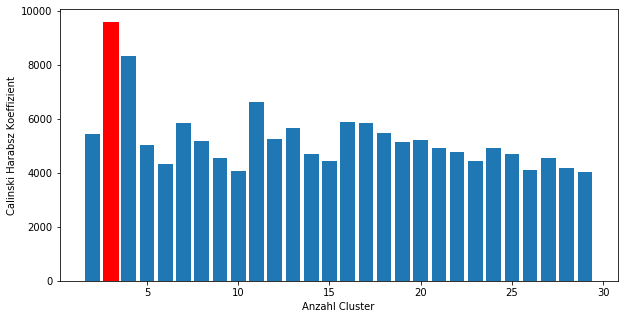

The optimal number of clusters is 3.


In [27]:
if cluster_method == CLUSTER_METHOD.KMEANS.value:
    plt.figure(figsize=(10,5))
    bars = plt.bar(x=results["number_of_clusters"], height=results["calinski_score"])
    plt.xlabel("Anzahl Cluster")
    plt.ylabel("Calinski Harabsz Koeffizient") 
    bars[results["calinski_score"].idxmax()].set_color("r")
    plt.show()
    plt.close()
    print("The optimal number of clusters is {}.".format(optimal_number_of_clusters))

# Clustering

In [28]:
filename_features = "clusteranalysis_features_{}_{}_{}_{}_{}_{}_{}.json".format(address_selection, outlier_removal, cluster_method, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end), hash(str(include_features)))
filename_features_std = "clusteranalysis_features_std_{}_{}_{}_{}_{}_{}_{}.json".format(address_selection, outlier_removal, cluster_method, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end), hash(str(include_features)))
filename_features_std_pca = "clusteranalysis_features_std_pca_{}_{}_{}_{}_{}_{}_{}.json".format(address_selection, outlier_removal, cluster_method, number_of_addresses, re.sub(r'[-.+: ]', '_', observation_period_start),re.sub(r'[-.+: ]', '_', observation_period_end), hash(str(include_features)))        

if cluster_method == CLUSTER_METHOD.KMEANS.value:
    cluster_model = KMeans(n_clusters=optimal_number_of_clusters)

if cluster_method == CLUSTER_METHOD.OPTICS.value:
    cluster_model = OPTICS(min_cluster_size=30, metric="cosine")
    
if filename_features not in os.listdir("./data") or filename_features_std not in os.listdir(data_dir) or filename_features_std_pca not in os.listdir(data_dir) or reset_clustering_result == True:
     
    print("Clustering data ...")
    start = time.time();

    cluster_model.fit(features_std_pca)
    
    features["label"] = cluster_model.labels_
    
    if cluster_method == CLUSTER_METHOD.OPTICS.value:
        features["reachability"] = cluster_model.reachability_
        features["core_distances"] = cluster_model.core_distances_
        features["ordering"] = cluster_model.ordering_
            
    # save clustering results in order to save time in the next run
    with open('{}/{}'.format(data_dir, filename_features), 'w') as json_file:
        json.dump(features.to_dict(), json_file, use_decimal=True, default=str)
    with open('{}/{}'.format(data_dir, filename_features_std), 'w') as json_file:
        json.dump(features_std.to_dict(), json_file, use_decimal=True, default=str)
    with open('{}/{}'.format(data_dir, filename_features_std_pca), 'w') as json_file:
        json.dump(features_std_pca.to_dict(), json_file, use_decimal=True, default=str) 
        
    done = time.time();
    elapsed = round(done - start);
    print("Done. Time to cluster data: {} Minutes.".format(round(elapsed/60)))
    
else:
    
    print("Loading data from local cache.")
    
    start = time.time();
    
    with open('./data/{}'.format(filename_features), "r") as file:  
        file_content_json = json.load(file);
    features = pd.DataFrame(file_content_json) 
    
    with open('./data/{}'.format(filename_features_std), "r") as file:  
        file_content_json = json.load(file);
    features_std = pd.DataFrame(file_content_json) 
    
    with open('./data/{}'.format(filename_features_std_pca), "r") as file:  
        file_content_json = json.load(file);
    features_std_pca = pd.DataFrame(file_content_json)     
    
    cluster_model.labels_ = features["label"].reset_index(drop=True)
    
    if cluster_method == CLUSTER_METHOD.OPTICS.value:
        cluster_model.reachability_ = features["reachability"].reset_index(drop=True)
        cluster_model.core_distances_ = features["core_distances"].reset_index(drop=True)
        cluster_model.ordering_ = features["ordering"].reset_index(drop=True)

    print("Done.")

if cluster_method == CLUSTER_METHOD.OPTICS.value:
    features = features.drop(columns=["reachability"])
    features = features.drop(columns=["core_distances"])
    features = features.drop(columns=["ordering"])

Clustering data ...
Done. Time to cluster data: 0 Minutes.


In [29]:
print("Number of Clusters {}".format(len(features["label"].unique())))

Number of Clusters 3


In [30]:
if cluster_method == CLUSTER_METHOD.OPTICS.value:
    plt.figure(figsize=(10,5))
    plt.xlabel('Ordered Data Objects')
    plt.ylabel('Reachability Distance') #for each component
    plt.title('OPTICS Reachability Diagram')
    plt.plot(cluster_model.reachability_[cluster_model.labels_ != -1])

# Remove outliers for OPTICS

In [31]:
labels = pd.Series(data=cluster_model.labels_, index=features.index)
if cluster_method == CLUSTER_METHOD.OPTICS.value:
    features_clean = features[labels != -1]
    features_std_clean = features_std[labels != -1]
    features_std_pca_clean = features_std_pca[labels != -1]

# Remove outliers for each cluster via variance threshold

In [32]:
def remove_outliers(features, cluster_model, threshold):
    
    features_without_outliers = pd.DataFrame()
    labels_without_outliers = []

    for label in np.unique(cluster_model.labels_):
        centroid = np.array(features_std_pca[cluster_model.labels_ == label].mean())

        features_within_cluster = features[cluster_model.labels_ == label];
        # distance of each point in cluster to cluster's centroid
        distances = features_within_cluster - centroid;
        # convert to scalar
        distances_norm = np.linalg.norm(distances, axis=1);
        # max_distance for this cluster
        max_distance = threshold * np.linalg.norm(features_within_cluster.std())
        
        keep = distances_norm <= max_distance
        
        features_without_outliers = features_without_outliers.append(features_within_cluster[keep])
        labels_without_outliers.extend([label for i in features_within_cluster[keep].iterrows()])
        
    features_without_outliers["label"] = labels_without_outliers
    return features_without_outliers

The threshold leading to the highest Calinski Harabaz Score is 0.3789842105263158


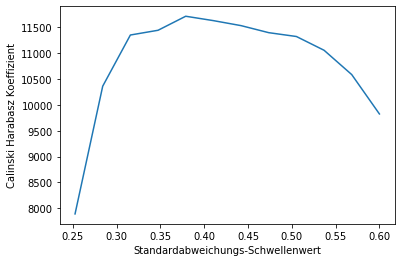

In [33]:
if outlier_removal == OUTLIER_REMOVAL.VARIANCE_THRESHOLD_WITHIN_CLUSTER.value:
    from sklearn.metrics import calinski_harabaz_score as ch_score
    
    thresholds = np.linspace(.0001,.6, 20)
    
    features_tables_without_outliers = [remove_outliers(features_std_pca, cluster_model, t) for t in thresholds]
    
    scores= []
    res = []
    
    for f,t in zip(features_tables_without_outliers, thresholds):
        if not f.empty and len(f["label"].unique()) > 1 and len(f) > 4:
            scores.append((metrics.calinski_harabasz_score(f.drop(columns=["label"]), f["label"]), t))
            res.append(f)
            
    scores = [x for x in zip(*scores)]
    
    plt.plot(scores[1], scores[0])
    plt.xlabel("Standardabweichungs-Schwellenwert")
    plt.ylabel("Calinski Harabasz Koeffizient") 
    
    optimal_threshold = list(scores[1])[np.argmax(list(scores[0]))]
    features_std_pca_without_outliers = res[np.argmax(scores)]
    features_clean = features.reindex(features_std_pca_without_outliers.index)
    features_std_clean = features_std.reindex(features_std_pca_without_outliers.index)
    features_std_pca_clean = features_std_pca.reindex(features_std_pca_without_outliers.index)  
    
    print("The threshold leading to the highest Calinski Harabaz Score is", optimal_threshold)

In [34]:
print("Es wurden {} Adressen eliminiert.".format(len(features_std) -  len(features_std_clean)))

Es wurden 5243 Adressen eliminiert.


## Display principal components

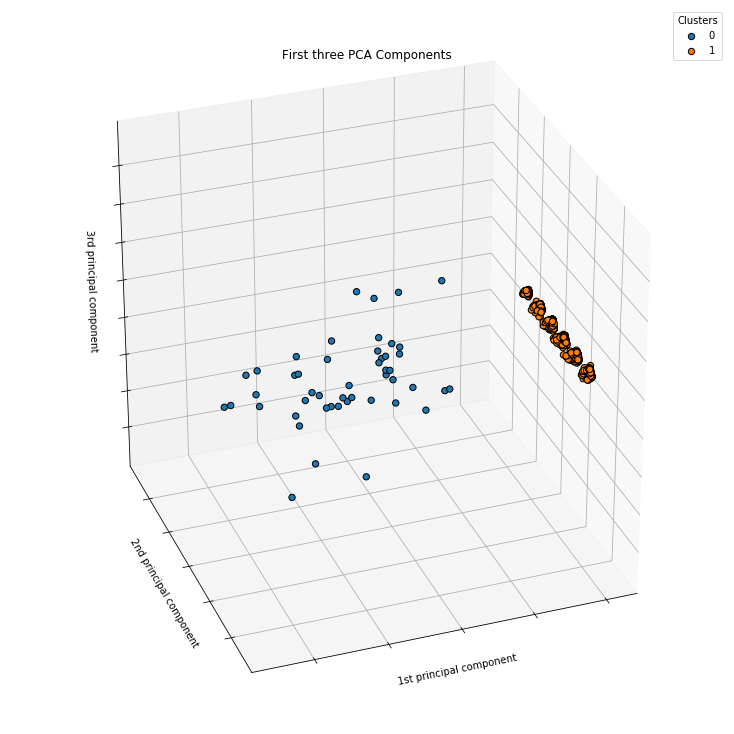

In [37]:
from mpl_toolkits.mplot3d import Axes3D;

fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

pca_tmp = PCA(n_components=3)
features_std_pca_tmp = pca_tmp.fit_transform(features_std_clean);
features_std_pca_tmp = pd.DataFrame(features_std_pca_tmp)
features_std_pca_tmp.index = features_clean.index 
features_std_pca_tmp.columns = ["1st eigenvector", "2st eigenvector", "3st eigenvector"] 
features_std_pca_tmp["label"] = features_clean["label"]

labels = np.sort(features_std_pca_tmp.label.unique())

for l in labels:
    ax.scatter(features_std_pca_tmp["1st eigenvector"][features_std_pca_tmp["label"] == l], 
           features_std_pca_tmp["2st eigenvector"][features_std_pca_tmp["label"] == l],
           features_std_pca_tmp["3st eigenvector"][features_std_pca_tmp["label"] == l],
           label = l, 
           edgecolor='k', s=40, alpha = 1);

ax.set_title("First three PCA Components");
ax.set_xlabel("1st principal component");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd principal component");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd principal component");
ax.w_zaxis.set_ticklabels([]);

number_of_clusters = len(features_clean["label"].unique())
if number_of_clusters < 50:
    ax.legend(title= "Clusters")
else:
    ax.annotate("Number of clusters: {}".format(number_of_clusters), xy=(0.85,0.85), xycoords='axes fraction',
             fontsize=14)

# Display cluster means 

In [38]:
clusters = dict() 
labels = features_clean["label"].unique()
labels.sort()

for label in labels:
    cluster_name = 'cluster_{}'.format(label)
    
    features_in_cluster = features_clean[features_clean.label == label]
    
    clusters[cluster_name] = dict()
    clusters[cluster_name]["number_of_addresses"] = Counter(features_clean["label"])[label]
    clusters[cluster_name]["feature_means"] = features_in_cluster.drop(columns=["label"]).mean()
    
feature_means = pd.DataFrame(columns = clusters[cluster_name]['feature_means'].keys())

for key in clusters:
    clusters[key]["feature_means"].name = key
    feature_means = feature_means.append(clusters[key]["feature_means"])

In [39]:
feature_means_display = feature_means.round()

if "wei_received" in feature_means_display.columns:
    feature_means_display["eth_received"] = feature_means_display["wei_received"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["wei_received"])

if "wei_sent" in feature_means_display.columns:
    feature_means_display["eth_sent"] = feature_means_display["wei_sent"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["wei_sent"])

    
if "balance" in feature_means_display.columns:
    feature_means_display["eth_balance"] = feature_means_display["balance"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["balance"])
    
if "avg_wei_sent" in feature_means_display.columns:
    feature_means_display["avg_eth_sent"] = feature_means_display["avg_wei_sent"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["avg_wei_sent"])
    
if "avg_wei_received" in feature_means_display.columns:
    feature_means_display["avg_eth_received"] = feature_means_display["avg_wei_received"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["avg_wei_received"])
    
if "monthly_wei_sent" in feature_means_display.columns:
    feature_means_display["monthly_eth_sent"] = feature_means_display["monthly_wei_sent"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["monthly_wei_sent"])
    
if "monthly_wei_received" in feature_means_display.columns:
    feature_means_display["monthly_eth_received"] = feature_means_display["monthly_wei_received"] / 10**18
    feature_means_display = feature_means_display.drop(columns=["monthly_wei_received"])
    
feature_means_display["number_of_addresses"] = [clusters[c]["number_of_addresses"] for c in clusters]

if set(["number_of_addresses", "eth_balance", "eth_sent", "eth_received"]).issubset(set(feature_means_display.columns)):
    cols = list(feature_means_display.columns.values) 
    cols.pop(cols.index('number_of_addresses')) 
    cols.pop(cols.index('eth_balance')) 
    cols.pop(cols.index('eth_sent')) 
    cols.pop(cols.index('eth_received')) 
    feature_means_display = feature_means_display[["number_of_addresses", "eth_balance", "eth_sent", "eth_received"]+cols] 


if len(feature_means_display.columns) > len(feature_means_display.index):
    print("Number of Addresses: {}".format(number_of_addresses))
    print("Observation-Period: {} to {}".format(observation_period_start, observation_period_end))
    display(feature_means_display.T.astype("int"))
else:
    display(feature_means_display.astype("int").sort_values(by="number_of_addresses", ascending=False))

Number of Addresses: 10000
Observation-Period: 2019-06-01 00:00:00+00 to 2020-01-01 00:00:00+00


,cluster_0,cluster_1
number_of_addresses,48,2087
eth_balance,13871,15
eth_sent,1430317,8738
eth_received,1444189,8754
number_of_tx_received,46945,102
number_of_tx_sent,69949,154
avg_time_diff_received_tx,11196,332044
avg_time_diff_sent_tx,8203,285319
mined_blocks,0,2
stddev_received_tx,28600,574348


# Display Cluster means with standardised features via radar plots

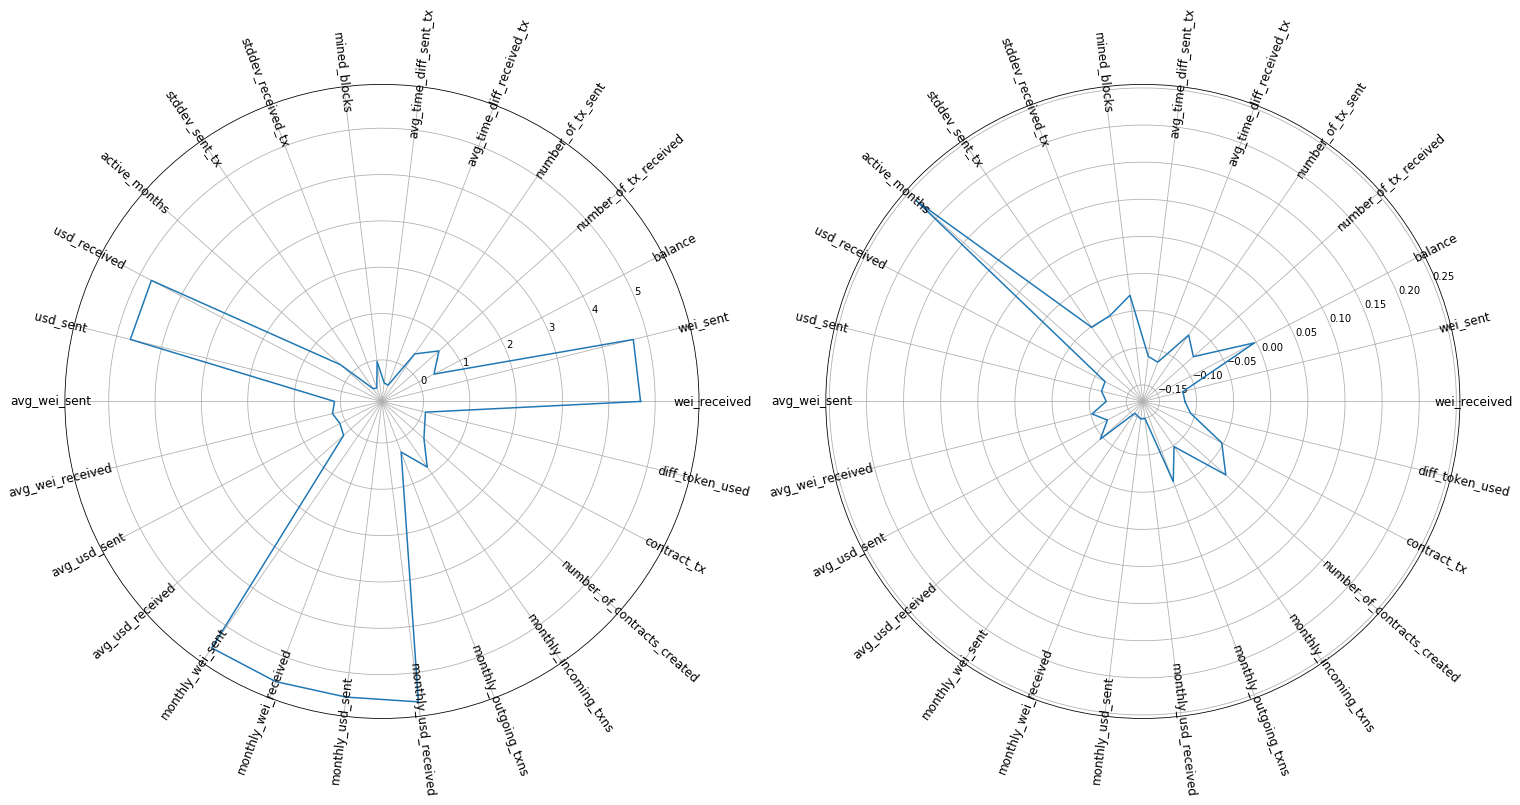

In [47]:
import math
number_of_clusters = len(features_clean["label"].unique())
number_of_attributes = len(feature_means.columns)
feature_std_means = pd.DataFrame(columns=feature_means.columns)
values = {}
    
if number_of_clusters < 10:
 
    # get all feature means for each cluster and make sure that the means are positive
    # for label in labels:
    for label in [0, 1]:
        features_std_in_cluster = features_std_clean[features_clean["label"] == label]
        feature_std_means_in_cluster = features_std_in_cluster.mean()
        feature_std_means_in_cluster.name = 'cluster_{}'.format(label)
#         feature_std_means_in_cluster_positive = feature_std_means_in_cluster + abs(max(feature_std_means_in_cluster, key=abs))
        feature_std_means_in_cluster_positive = feature_std_means_in_cluster
        feature_std_means = feature_std_means.append(feature_std_means_in_cluster_positive)
    
    for i,v in feature_std_means.iterrows(): 
        tmp_values = feature_std_means.loc[i].values.tolist()
        tmp_values += tmp_values[:1]
        values[i] = tmp_values
        
    angles = [n / float(number_of_attributes) * 2 * math.pi for n in range(number_of_attributes)]
    angles += angles[:1]
    
    fig = plt.figure(figsize=(25,len(values) * 10))
    
    i = 0
    
    for cluster_name, cluster_values in values.items():
        i+=1
        ax = plt.subplot(math.ceil(len(values)/2), 2, i, projection='polar')
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features_clean.columns)
        ax.plot(angles, cluster_values)
#         ax.set_rticks([]) 

        plt.gcf().canvas.draw()
        angles_tmp = np.linspace(0,2*np.pi,len(ax.get_xticklabels())+1)
        angles_tmp[np.cos(angles_tmp) < 0] = angles_tmp[np.cos(angles_tmp) < 0] + np.pi
        angles_tmp = np.rad2deg(angles_tmp)
        labels = []
        for label, angle in zip(ax.get_xticklabels(), angles_tmp):
            x,y = label.get_position()
            lab = ax.text(x,y, label.get_text(), transform=label.get_transform(),
                          ha=label.get_ha(), va=label.get_va(), size=12)
            lab.set_rotation(angle)
            labels.append(lab)
        ax.set_xticklabels([])

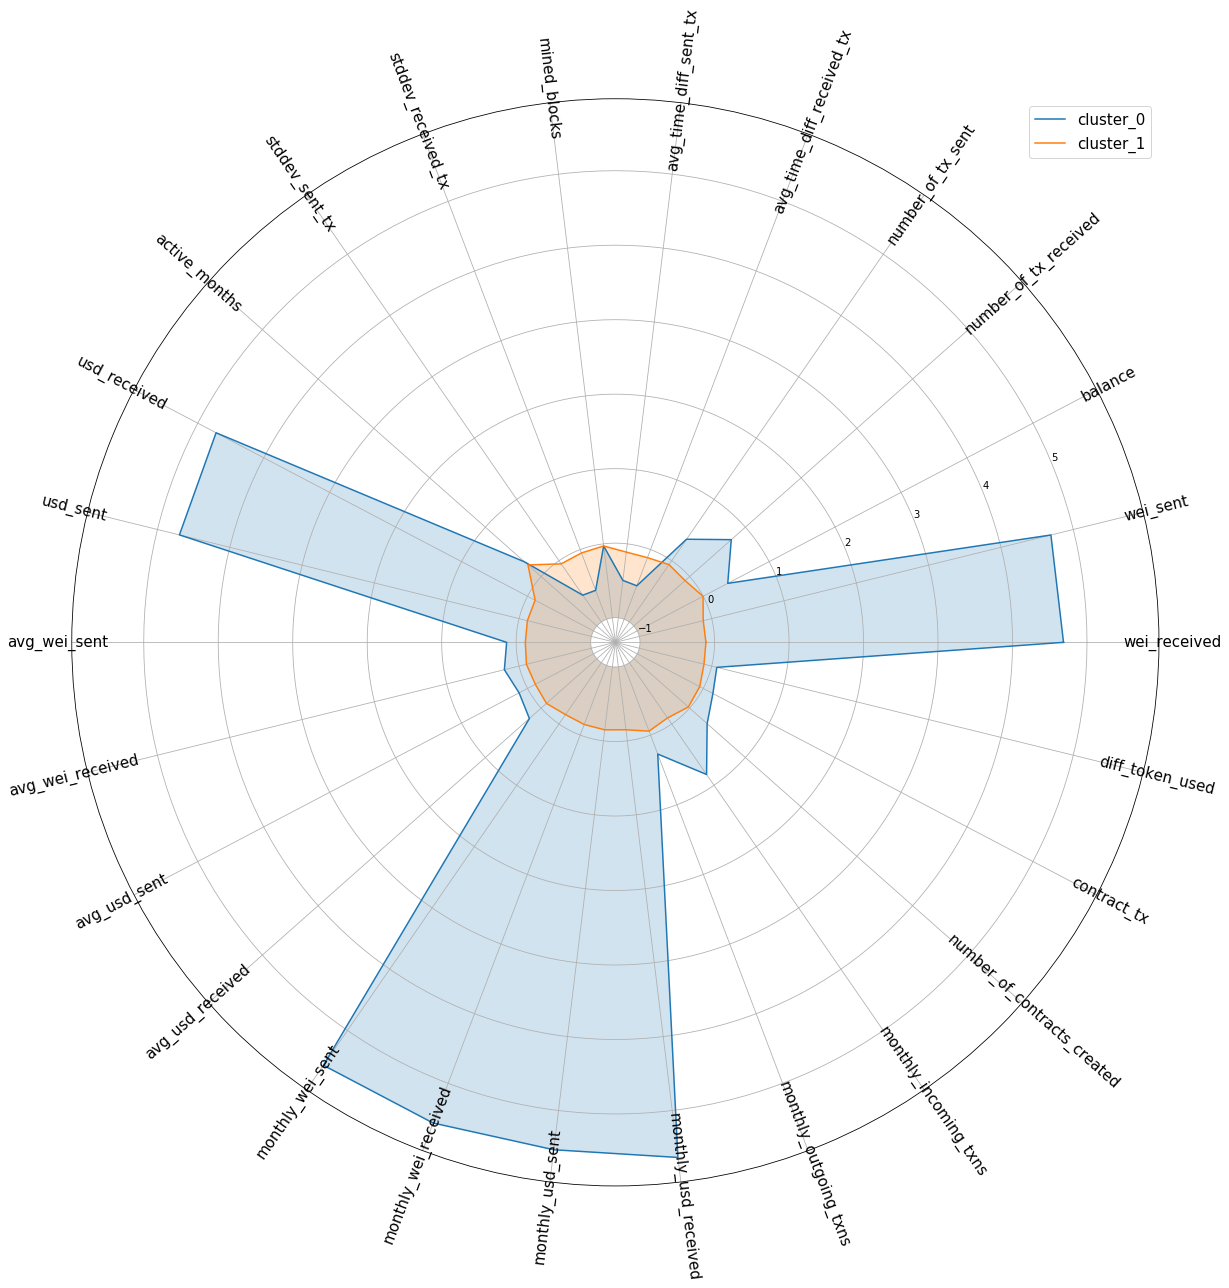

In [48]:
import math
number_of_clusters = len(features_clean["label"].unique())
number_of_attributes = len(feature_means.columns)
feature_std_means = pd.DataFrame(columns=feature_means.columns)
values = {}
    
if number_of_clusters < 10:
 
    # get all feature means for each cluster and make sure that the means are positive
    # for label in labels:
    for label in [0, 1]:
        features_std_in_cluster = features_std_clean[features_clean["label"] == label]
        feature_std_means_in_cluster = features_std_in_cluster.mean()
        feature_std_means_in_cluster.name = 'cluster_{}'.format(label)
#         feature_std_means_in_cluster_positive = feature_std_means_in_cluster + abs(max(feature_std_means_in_cluster, key=abs))
        feature_std_means_in_cluster_positive = feature_std_means_in_cluster
        feature_std_means = feature_std_means.append(feature_std_means_in_cluster_positive)
    
    for i,v in feature_std_means.iterrows(): 
        tmp_values = feature_std_means.loc[i].values.tolist()
        tmp_values += tmp_values[:1]
        values[i] = tmp_values
        
    angles = [n / float(number_of_attributes) * 2 * math.pi for n in range(number_of_attributes)]
    angles += angles[:1]
    
    fig = plt.figure(figsize=(25,len(values) * 10))
    
    i = 0
    
    ax = plt.subplot(111, projection='polar')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features_clean.columns)
        
    for cluster_name, cluster_values in values.items():
        ax.plot(angles, cluster_values)
        ax.fill_between(angles, cluster_values, -1, alpha=0.2)

    plt.gcf().canvas.draw()
    angles_tmp = np.linspace(0,2*np.pi,len(ax.get_xticklabels())+1)
    angles_tmp[np.cos(angles_tmp) < 0] = angles_tmp[np.cos(angles_tmp) < 0] + np.pi
    angles_tmp = np.rad2deg(angles_tmp)
    labels = []
    for label, angle in zip(ax.get_xticklabels(), angles_tmp):
        x,y = label.get_position()
        lab = ax.text(x,y, label.get_text(), transform=label.get_transform(),
                          ha=label.get_ha(), va=label.get_va(), size=15)
        lab.set_rotation(angle)
        labels.append(lab)
    ax.set_xticklabels([])
    ax.legend(values.keys(), fontsize=15, loc="upper right")

# Clustering Evaluation: Recall, Precision and F1 score 

In [49]:
def scrapeAddressesFromEtherscan(etherscan_cookie, label):
    filename = "{}.labelcloud.json".format(label)
    if filename not in os.listdir("./data"):
        from urllib.request import urlopen, Request
        from bs4 import BeautifulSoup
        addresses = []
        headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3", "cookie": etherscan_cookie}
        reg_url = "https://etherscan.io/accounts/label/{}/2?size=500".format(label)
        req = Request(url=reg_url, headers=headers) 
        html = urlopen(req).read().decode('utf-8')
        soup = BeautifulSoup(html, 'html.parser')
        elements = soup.find_all("tr")
        elements = list(elements)[1:-1]
        addresses.extend([e.contents[0].get_text().strip(" ") for e in elements])
        import json
        with open('./data/{}'.format(filename), 'w+') as json_file:
            json.dump(addresses, json_file)
    else:    
        with open("./data/{}".format(filename), newline="") as json_file:
            import json
            addresses = json.load(json_file);
    return addresses

**Attention: The cookie needs to be retrieved manually by logging in to etherscan.io and reading the cookie from the http header**

In [50]:
cookie_tmp = "_ga=GA1.2.1527232323.1586268698; etherscan_cookieconsent=True; __cfduid=d863ce6ff66e1368392ffacef0fafb0a01596187770; _gid=GA1.2.723960372.1596782422; ASP.NET_SessionId=hv4wqut1sad2a2lz4vtxqmo2"

In [51]:
exchange_addresses = scrapeAddressesFromEtherscan(cookie_tmp, "exchange")
mining_addresses = scrapeAddressesFromEtherscan(cookie_tmp, "mining")

In [52]:
def mergeWithLabeledAddresses(all_addresses, cluster_labels, labeled_addresses, label):
    tmp = pd.DataFrame(columns=[label])
    for addr in list(all_addresses):
        if addr.lower() in labeled_addresses:
            tmp = tmp.append(pd.Series(1, name=addr, index=[label]))
    tmp = tmp.reindex(index=all_addresses)
    tmp = tmp.fillna(0)
    tmp[label] = tmp[label].astype("int")
    tmp["cluster_label"] = cluster_labels
    
    result = []
    for cluster_label in tmp.cluster_label.unique():
        result.append(tmp[tmp["cluster_label"] == cluster_label][label])
    
    return result

cluster_list_exchange = mergeWithLabeledAddresses(features_clean.index, features_clean.label, exchange_addresses, "exchange")
cluster_list_mining = mergeWithLabeledAddresses(features_clean.index, features_clean.label, mining_addresses, "mining")

Text(0, 0.5, 'Number of exchanges / miners')

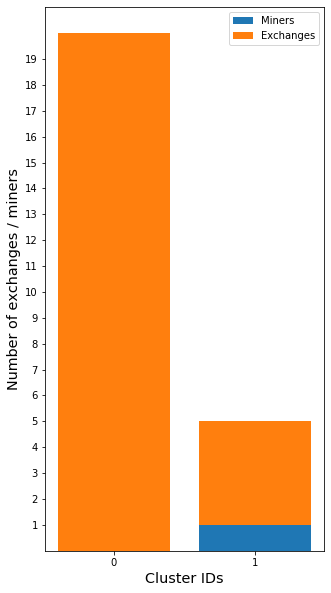

In [56]:
cluster_labels = features_clean.label.unique()

values_mining = [Counter(cluster_list_mining[c])[1] for c in range(0, len(cluster_list_mining))]
series_mining = pd.Series(values_mining, index=cluster_labels)

values_exchange = [Counter(cluster_list_exchange[c])[1] for c in range(0, len(cluster_list_exchange))]
series_exchange = pd.Series(values_exchange, index=cluster_labels)


fig, ax = plt.subplots(figsize= (5,10))
bar_mining = ax.bar(series_mining.index, series_mining)
bar_exchange = ax.bar(series_exchange.index, series_exchange, bottom=series_mining)

bar_mining.set_label("Miners")
bar_exchange.set_label("Exchanges")
ax.legend()

ax.set_xticks(cluster_labels)
ax.set_xticklabels(cluster_labels)

ax.set_yticks(range(1,max(series_mining+series_exchange)))

ax.set_xlabel("Cluster IDs", fontsize="x-large");
ax.set_ylabel("Number of exchanges / miners", fontsize="x-large")

In [58]:
import collections as collections
from math import factorial as fac

def b(x, y):
    try:
        binom = fac(x) // fac(y) // fac(x - y)
    except ValueError:
        binom = 0
    return binom

def getErrors(cluster_list):
    Counter = collections.Counter
    
    total_addresses= 0
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    counter_list = []
    
    # Calculate True Positives
    for c in range(0, len(cluster_list)): 
        # calculating total_addresses count...
        total_addresses += len(cluster_list[c])
    
        c = Counter(cluster_list[c])
        counter_list.append(c)
        
        TP += b(c[1], 2) 
    
    # Calculate False Positives
    for c in range(0, len(cluster_list)): 
        c = Counter(cluster_list[c])
        FP += c[1] * c[0]
    
    # Calculating False Negatives
    sum_counter = Counter()
    for c in counter_list:
        sum_counter += c
    
    for ct in counter_list:
        fn_temp = 0 
    
        fn_temp += ct[1]*(sum_counter[1]-ct[1])
        sum_counter -= ct
        FN += fn_temp

    # Calculating True Negatives
    sum_counter = Counter()
    for c in counter_list:
        sum_counter += c

    for ct in counter_list:
        tn_temp = 0 
        tn_temp += ct[0]*(sum_counter[0]-ct[0])
        sum_counter -= ct
        TN += tn_temp
        
    print("TP is %d " % TP)
    print("FP is %d " % FP)
    print("TN is %d " % TN)
    print("FN is %d " % FN)
    
    return TP, FP, TN, FN

In [59]:
TP_Exchanges, FP_Exchanges, TN_Exchanges, FN_Exchanges = getErrors(cluster_list_exchange)
TP_Miners, FP_Miners, TN_Miners, FN_Miners = getErrors(cluster_list_mining)

TP = TP_Exchanges + TP_Miners
FP = FP_Exchanges + FP_Miners
TN = TN_Exchanges + TN_Miners
FN = FN_Exchanges + FN_Miners

if TP > 0:
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1=(2*Recall*Precision)/(Recall+Precision)
else:
    Precision = 0
    Recall = 0
    F1 = 0
    
print("Precision is %.4f " % Precision)
print("Recall is %.4f " % Recall)
print("F1 is %.4f " % F1)

TP is 196 
FP is 8892 
TN is 58324 
FN is 80 
TP is 0 
FP is 2086 
TN is 100128 
FN is 0 
Precision is 0.0175 
Recall is 0.7101 
F1 is 0.0342 
